# **NYC TAXI**

### Dependency checks

In [32]:
%pip install -r ../requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geodatasets]
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [3]:
trainFull = pd.read_csv('../data/train.csv')
testFull = pd.read_csv('../data/test.csv')

### Checking for missing values

In [4]:
# Check for missing values in each column
missing_counts = trainFull.isnull().sum()

# Display columns that have missing values (if any)
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

if trainFull.isnull().values.any():
    print("\nThe dataset contains missing values.")
else:
    print("\nThe dataset has no missing values.")


Missing values per column:
Series([], dtype: int64)

The dataset has no missing values.


### Consistency check : **trip times**

In [10]:
import pandas as pd
import numpy as np

def check_duration_consistency(data, tolerance=1):    
    # Ensure datetimes are actually datetime objects
    # (pickup_datetime is already converted in your create_datetime_features, but dropoff might not be)
    pickup = pd.to_datetime(data['pickup_datetime'])
    dropoff = pd.to_datetime(data['dropoff_datetime'])
    
    # Calculate duration in seconds
    calculated_duration = (dropoff - pickup).dt.total_seconds()
    
    # Calculate the absolute difference
    diff = np.abs(data['trip_duration'] - calculated_duration)
    
    # Find inconsistencies
    inconsistent_mask = diff > tolerance
    num_inconsistent = inconsistent_mask.sum()
    
    if num_inconsistent == 0:
        print("All trip_duration values are consistent with timestamps.")
    else:
        print(f"Found {num_inconsistent} records with inconsistent durations (diff > {tolerance}s).")
        
        # Show some examples of inconsistent rows
        bad_rows = data[inconsistent_mask].copy()
        bad_rows['calculated_duration'] = calculated_duration[inconsistent_mask]
        bad_rows['diff'] = diff[inconsistent_mask]
        
        print("\nTop 5 biggest inconsistencies:")
        cols_to_show = ['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'calculated_duration', 'diff']
        print(bad_rows.sort_values('diff', ascending=False)[cols_to_show].head())

# Run the check on your trainFull dataset
check_duration_consistency(trainFull)

All trip_duration values are consistent with timestamps.


# **Feature Visualizations**

## Plotting pickup coordinates

In [11]:
# First install: %pip install plotly
import plotly.express as px

# Sample the data (full dataset is too large to plot)
sample = trainFull.sample(n=10000, random_state=42)

# Plot pickups
fig = px.scatter_mapbox(
    sample,
    lat='pickup_latitude',
    lon='pickup_longitude',
    size_max=5,
    zoom=10,
    center={'lat': 40.7128, 'lon': -74.0060},
    mapbox_style='carto-positron',
    title='NYC Taxi Pickups',
    opacity=0.5
)
fig.show()

/var/folders/fg/jt9mq0js5cqgg812yfmz3gg00000gp/T/ipykernel_30231/3233829698.py:8: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



####Most pickups are coming from Manhattan, other notable pickup spots are from JFK airport 

## Date/time vs trip duration

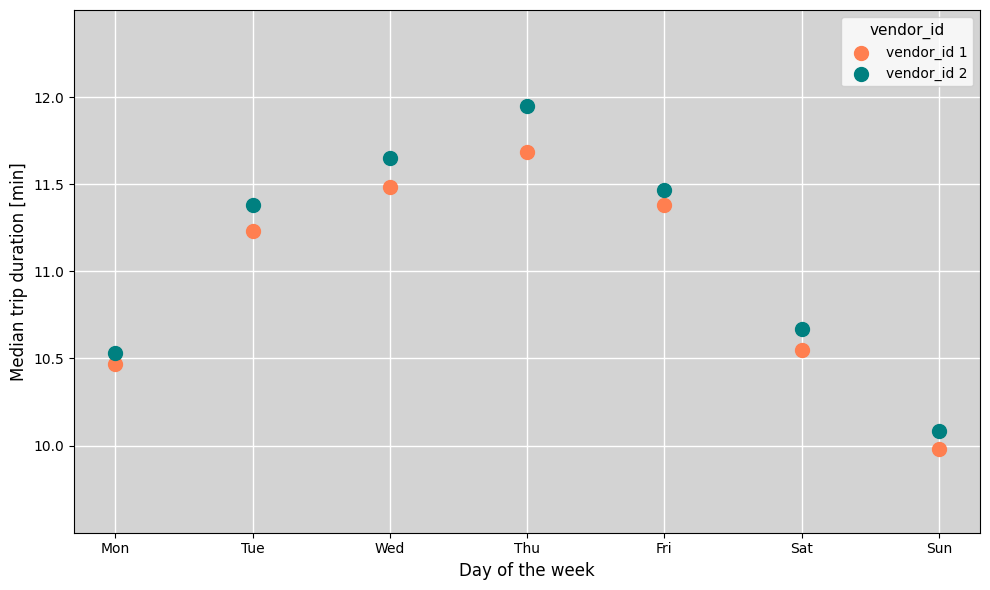

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

trainFull['pickup_datetime'] = pd.to_datetime(trainFull['pickup_datetime'])
trainFull['pickup_dayofweek'] = trainFull['pickup_datetime'].dt.dayofweek
# Convert trip_duration from seconds to minutes
trainFull['trip_duration_min'] = trainFull['trip_duration'] / 60

# Map day of week numbers to day names
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
trainFull['day_name'] = trainFull['pickup_dayofweek'].map({i: day_names[i] for i in range(7)})

# Calculate median trip duration by day of week and vendor_id
median_duration = trainFull.groupby(['day_name', 'vendor_id'])['trip_duration_min'].median().reset_index()
median_duration = median_duration.sort_values(['day_name', 'vendor_id'])

# Ensure correct order of days
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
median_duration['day_name'] = pd.Categorical(median_duration['day_name'], categories=day_order, ordered=True)
median_duration = median_duration.sort_values('day_name')

# Create the visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Separate data by vendor_id
vendor_1 = median_duration[median_duration['vendor_id'] == 1]
vendor_2 = median_duration[median_duration['vendor_id'] == 2]

# Plot scatter points
ax.scatter(vendor_1['day_name'], vendor_1['trip_duration_min'], 
           color='coral', s=100, label='vendor_id 1', zorder=3)
ax.scatter(vendor_2['day_name'], vendor_2['trip_duration_min'], 
           color='teal', s=100, label='vendor_id 2', zorder=3)

# Styling to match the image
ax.set_xlabel('Day of the week', fontsize=12)
ax.set_ylabel('Median trip duration [min]', fontsize=12)
ax.set_facecolor('lightgrey')
ax.grid(True, color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
ax.legend(title='vendor_id', fontsize=10, title_fontsize=11)

# Set y-axis limits and ticks to match the style
ax.set_ylim(bottom=9.5, top=12.5)
ax.set_yticks([10.0, 10.5, 11.0, 11.5, 12.0])

plt.tight_layout()
plt.show()

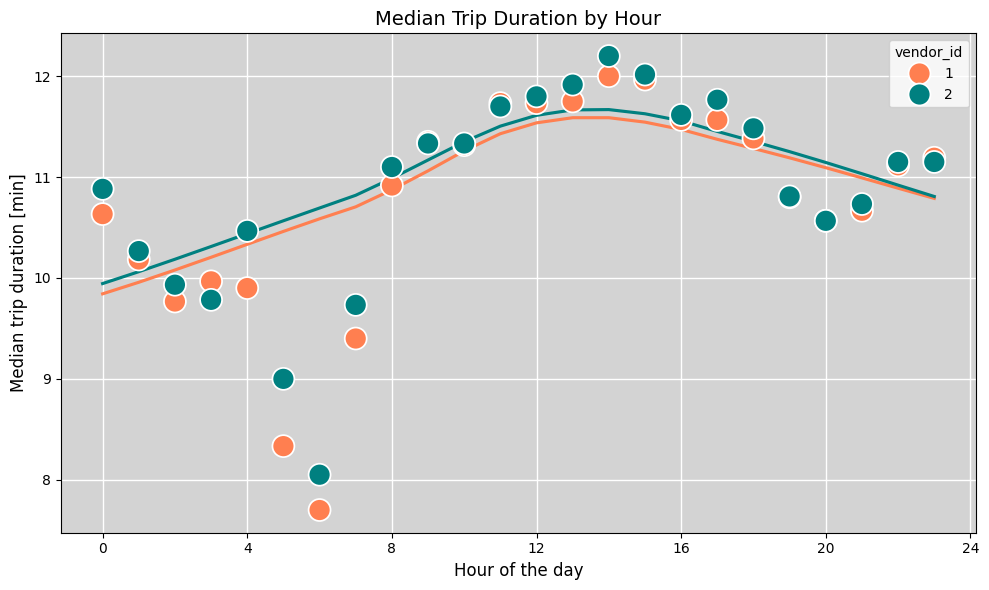

In [20]:
if 'pickup_hour' not in trainFull.columns:
    trainFull['pickup_hour'] = trainFull['pickup_datetime'].dt.hour

# Calculate median duration per hour and vendor
summary_data = trainFull.groupby(['pickup_hour', 'vendor_id'])['trip_duration_min'].median().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

colors = {1: 'coral', 2: 'teal'}

# Add SMOOTHING curves
for vendor in [1, 2]:
    subset = summary_data[summary_data['vendor_id'] == vendor]
    if not subset.empty:
        sns.regplot(
            data=subset,
            x='pickup_hour',
            y='trip_duration_min',
            scatter=False,
            lowess=True,
            color=colors[vendor],
            ax=ax
        )

# Add POINTS
sns.scatterplot(
    data=summary_data,
    x='pickup_hour',
    y='trip_duration_min',
    hue='vendor_id',
    palette=colors,
    s=250,
    ax=ax,
    zorder=3
)

# 3. Styling
ax.set_xlabel("Hour of the day", fontsize=12)
ax.set_ylabel("Median trip duration [min]", fontsize=12)
ax.set_title("Median Trip Duration by Hour", fontsize=14)
ax.set_xticks(range(0, 25, 4))  
ax.set_facecolor('lightgrey')
ax.grid(True, color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)

# Remove legend if desired
ax.get_legend()

plt.tight_layout()
plt.show()

#####There is a pattern for days of the week and hour of days. Seems that trip duration tend to be quicker towards quieter hours in the day and quiter days in the week. 

## Date/time vs passengers

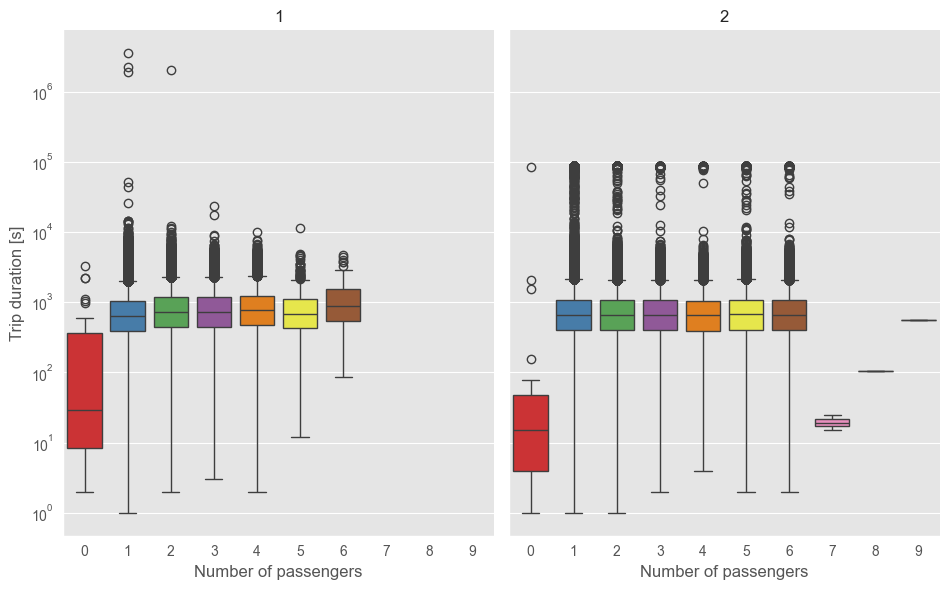

In [ ]:
sns.set_style("whitegrid")
plt.style.use('ggplot')

# Create a FacetGrid for the two vendors
g = sns.FacetGrid(trainFull, col='vendor_id', height=6, aspect=0.8)

# Map boxplot to each facet with different colors per passenger_count
g.map_dataframe(
    sns.boxplot,
    x='passenger_count',
    y='trip_duration',
    hue='passenger_count',
    palette='Set1', 
    legend=False
)

# Set log scale on y-axis
for ax in g.axes.flat:
    ax.set_yscale('log')

# Labels
g.set_axis_labels('Number of passengers', 'Trip duration [s]')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

#####Without any passengers both vendors have short trips. 
#####Vendor 1 has trip_durations beyond 24 hours which we will remove during cleaning. Vendor 2 has all (five) trips iwht more than 6 passengers and more trip durations that approach the 24 hour limit 

# **Create new features**

In [22]:
def create_datetime_features(data):
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

    #Extract time features
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day'] = data['pickup_datetime'].dt.day
    data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
    data['pickup_month'] = data['pickup_datetime'].dt.month

    #Pretty cool thing here cuz you map the time and day to a circle so the model understands
    #That 12AM (hour 0) and 11PM (23) are not far apart for example
    data['pickup_hour_sin'] = np.sin(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_hour_cos'] = np.cos(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_dayofweek_sin'] = np.sin(2 * np.pi * data['pickup_dayofweek'] / 7)
    data['pickup_dayofweek_cos'] = np.cos(2 * np.pi * data['pickup_dayofweek'] / 7)

    return data

def create_geo_features(data):
    #Calculate the shortest distance through 2 points
    def haversine_distance(lat1, lon1, lat2, lon2):
        radius = 6371  #Earth radius in km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return radius * c

    #Very rough estimation of how you would actually drive to the point
    #since we can't drive through buildings
    def street_distance(lat1, lon1, lat2, lon2):
        lat_dist = haversine_distance(lat1, lon1, lat2, lon1)
        lon_dist = haversine_distance(lat1, lon1, lat1, lon2)
        return lat_dist + lon_dist

    data['haversine_distance'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['street_distance'] = street_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])

    #Taxi speeds depend on how far they are from the city's "center"
    #I chose the East Village in Manhattan but thats an arbitrary choice
    nyc_center = (40.72680913695419, -73.98296948105471) #East Village 131 Ave A

    data['dropoff_distance_from_center'] = haversine_distance(data['dropoff_latitude'], data['dropoff_longitude'], nyc_center[0], nyc_center[1])
    data['pickup_distance_from_center'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], nyc_center[0], nyc_center[1])

    return data

trainFull = create_datetime_features(trainFull)
trainFull = create_geo_features(trainFull)

In [23]:
# View original data structure
print("=== ORIGINAL DATA (trainFull) ===")
print(f"Shape: {trainFull.shape}")
print(f"\nColumns: {list(trainFull.columns)}")
print(f"\nFirst few rows:")
print(trainFull.head())
print(f"\nData types:")
print(trainFull.dtypes)

=== ORIGINAL DATA (trainFull) ===
Shape: (1458644, 25)

Columns: ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'trip_duration_min', 'pickup_dayofweek', 'day_name', 'pickup_hour', 'pickup_day', 'pickup_month', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_dayofweek_sin', 'pickup_dayofweek_cos', 'haversine_distance', 'street_distance', 'dropoff_distance_from_center', 'pickup_distance_from_center']

First few rows:
          id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pick

# **Cleaning Data**

###Extreme date trip durations
Here we are checking for data points that have `trip_durations` longer than 24hrs 

In [24]:
# Filter for trips longer than 24 hours (24 * 3600 seconds)
day_plus_trips = trainFull[trainFull['trip_duration'] > 24*3600].copy()

# Calculate speed in km/h (Distance is in km, Duration is in seconds)
# Note: This relies on 'haversine_distance' being present from your create_geo_features function
day_plus_trips['speed'] = day_plus_trips['haversine_distance'] / (day_plus_trips['trip_duration'] / 3600)

# Select the specific columns to create the view
result = day_plus_trips[['pickup_datetime', 'dropoff_datetime', 'speed']]

# Display the result (pandas DataFrame is the equivalent of a tibble)
print(result)

           pickup_datetime     dropoff_datetime     speed
355003 2016-01-05 00:19:42  2016-01-27 11:08:38  0.037394
680594 2016-02-13 22:38:00  2016-03-08 15:57:38  0.010508
924150 2016-01-05 06:14:15  2016-01-31 01:01:07  0.002642
978383 2016-02-13 22:46:52  2016-03-25 18:18:14  0.020317


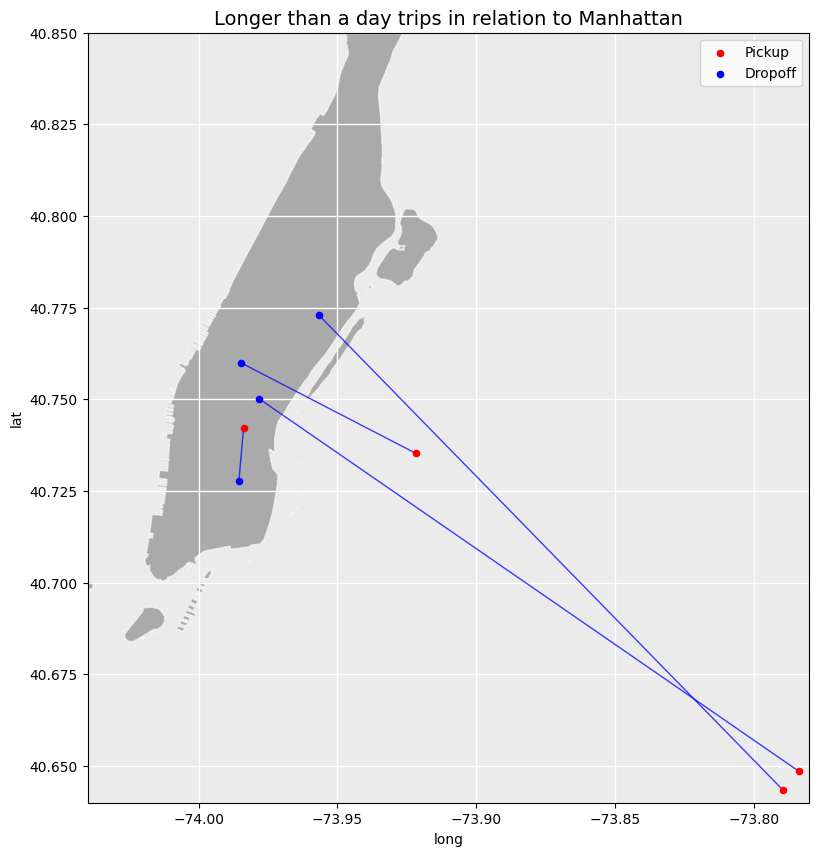

In [ ]:
import matplotlib.patches as patches
from geodatasets import get_path
import geopandas as gpd


fig, ax = plt.subplots(figsize=(12, 8))

path_to_data = get_path('nybb')
gdf = gpd.read_file(path_to_data)

manhattan = gdf[gdf['BoroName'] == 'Manhattan'].to_crs("EPSG:4326")

# Draw lines connecting Pickup to Dropoff for each trip
# (Iterating is fine here since there are very few data points > 24hrs)
for _, row in day_plus_trips.iterrows():
    ax.plot([row['pickup_longitude'], row['dropoff_longitude']], 
            [row['pickup_latitude'], row['dropoff_latitude']], 
            color='blue', alpha=0.75, linewidth=1)

# Draw Manhattan Polygon
manhattan.plot(ax=ax, color='grey', alpha=0.6, edgecolor='white')

# Pickup (Red)
ax.scatter(day_plus_trips['pickup_longitude'], day_plus_trips['pickup_latitude'], 
           color='red', s=20, label='Pickup', zorder=5)

# Dropoff (Blue)
ax.scatter(day_plus_trips['dropoff_longitude'], day_plus_trips['dropoff_latitude'], 
           color='blue', s=20, label='Dropoff', zorder=5)


ax.set_title("Longer than a day trips in relation to Manhattan", fontsize=14)
ax.set_xlabel("long")
ax.set_ylabel("lat")
ax.set_facecolor('#EBEBEB')  # Light grey background
ax.grid(True, color='white', linewidth=1)  # White grid lines

# Set limits to focus on the Manhattan/NYC area 
# (Based on the coordinates seen in your R plot example)
ax.set_xlim(-74.04, -73.78)
ax.set_ylim(40.64, 40.85)

ax.legend()
plt.show()

# **Feature selection**

In [ ]:
#Select features for the model
feature_columns = [
    # Geographic features
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'haversine_distance', 'street_distance',
    'pickup_distance_from_center', 'dropoff_distance_from_center',
    
    # Time features
    'pickup_hour_sin', 'pickup_hour_cos',
    'pickup_dayofweek_sin', 'pickup_dayofweek_cos',
    'pickup_day', 'pickup_month',
]

X = trainFull[feature_columns]
y = trainFull['trip_duration']

mask = ~np.isnan(y)
X_clean = X[mask]
Y_clean = y[mask]

#Scale Y
y_scaler = StandardScaler()
Y_clean = y_scaler.fit_transform(Y_clean.values.reshape(-1, 1)).ravel()

In [ ]:
#Split data
X_train, X_val, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.1, random_state=39)

print(f"Target stats - Min: {y_test.min()}, Max: {y_test.max()}, Mean: {y_test.mean()}, Std: {y_test.std()}")
print(f"Training shape: {X_train.shape}")
print(f"Target variance: {y_test.var()}")

# Hyperparameter tuning: Train models with different 

In [ ]:
hyperparams = {
    'learning_rate': [0.01, 0.05],
    'max_iter': [500, 1000],
    'max_depth': [5, 7, None],
    'min_samples_leaf': [10, 20],
    'l2_regularization': [0.1, 1, 10],
    'max_leaf_nodes': [63, 127],
    'max_bins': [255],
}

base_model = HistGradientBoostingRegressor(
    random_state=39,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='loss'
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=hyperparams,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=39,
    verbose=2
)

#fit the random search
print("Currently tuning hyperparameters. Sit tight...")
random_search.fit(X_train, y_train)



**Stats**

In [ ]:
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score: {random_search.best_score_}")

#Get the best model
best_model = random_search.best_estimator_

y_val_pred = best_model.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_test, y_val_pred))
print(f"Validation RMSE: {val_rmse}")